In [1]:
import torch
import random
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.datasets
import matplotlib.pyplot as plt

In [2]:
X, y = sklearn.datasets.make_circles()


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).view(-1, 1)
y_test = torch.FloatTensor(y_test).view(-1, 1)

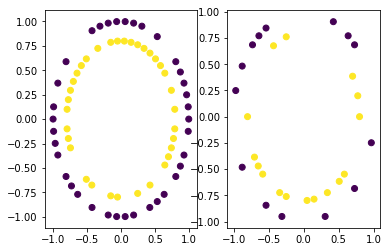

In [4]:
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten())
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.flatten())

In [243]:
class CircleNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(CircleNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)
        self.sm = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ(x)
        x = self.fc2(x)
        x = self.sm(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [244]:
net = CircleNet(20)
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), 
                             lr=1.0e-3)

In [245]:
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        train_preds = net.forward(X_train)
        train_loss = loss(train_preds, y_train)
        train_preds = train_preds >= 0.5
        test_preds = net.forward(X_test)
        test_loss = loss(test_preds, y_test)
        test_preds = test_preds >= 0.5
        print("Epoch {}".format(epoch))
        print("Train loss {:.4f}, Test loss {:.4f}".format(train_loss.item(), test_loss.item()))
        print("Train acc {:.4f}, test acc {:.4f}".format((train_preds == y_train).float().mean().item(),
                                                 (test_preds == y_test).float().mean().item()))

Epoch 0
Train loss 0.6957, Test loss 0.6984
Train acc 0.5286, test acc 0.4667
Epoch 100
Train loss 0.6633, Test loss 0.7103
Train acc 0.5857, test acc 0.4000
Epoch 200
Train loss 0.6334, Test loss 0.6891
Train acc 0.6286, test acc 0.4000
Epoch 300
Train loss 0.5947, Test loss 0.6657
Train acc 0.7143, test acc 0.4667
Epoch 400
Train loss 0.5486, Test loss 0.6349
Train acc 0.7714, test acc 0.6667
Epoch 500
Train loss 0.4998, Test loss 0.5998
Train acc 0.8571, test acc 0.7667
Epoch 600
Train loss 0.4504, Test loss 0.5601
Train acc 0.9286, test acc 0.8333
Epoch 700
Train loss 0.4038, Test loss 0.5234
Train acc 0.9571, test acc 0.8333
Epoch 800
Train loss 0.3604, Test loss 0.4865
Train acc 0.9714, test acc 0.8667
Epoch 900
Train loss 0.3198, Test loss 0.4488
Train acc 1.0000, test acc 0.8667
Epoch 1000
Train loss 0.2823, Test loss 0.4142
Train acc 1.0000, test acc 0.9000
Epoch 1100
Train loss 0.2487, Test loss 0.3833
Train acc 1.0000, test acc 0.9000
Epoch 1200
Train loss 0.2186, Test loss 

KeyboardInterrupt: 

In [ ]:
torch.sum(X_train).item()

In [324]:
class SGD_BB(torch.optim.Optimizer):
    def __init__(self, params, m, eta0, eta1, beta):
        defaults = dict(m=m, eta0=eta0, eta1=eta1, beta=beta)
        super(SGD_BB, self).__init__(params, defaults)
        self.g_curr = None
        self.g_prev = None
        self.x_prev = None
        if len(self.param_groups) != 1:
            raise ValueError("L-BFGS doesn't support per-parameter options "
                             "(parameter groups)")

        self._params = self.param_groups[0]['params']
        
    def _gather_flat_param(self):
        views = []
        for p in self._params:
            view = p.data.view(-1)
            views.append(view)
        return torch.cat(views, 0)   
        
    def _gather_flat_grad(self):
        views = []
        for p in self._params:
            if p.grad is None:
                view = p.data.new(p.data.numel()).zero_()
            elif p.grad.data.is_sparse:
                view = p.grad.data.to_dense().view(-1)
            else:
                view = p.grad.data.view(-1)
            views.append(view)
        return torch.cat(views, 0)
    
    def zero_grad(self):
        for p in self._params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()
        
    def step(self, closure=None):
        if closure is None:
            raise ValueError("Closure is not passed")
        
        group = self.param_groups[0]
        m = group['m']
        beta = group['beta']
        x_curr = self._gather_flat_param()
        
        if self.g_prev is not None:
            eta = 1 / m * torch.sum((x_curr - self.x_prev)**2)\
                        / torch.abs(torch.dot(x_curr - self.x_prev,
                                              self.g_curr - self.g_prev))
            eta = eta.item()
#             print(f"{x_curr} - {self.x_prev} = {x_curr - self.x_prev}")
#             print(f"{self.g_curr} - {self.g_prev} = {self.g_curr - self.g_prev}")
            print(np.linalg.norm(x_curr - self.x_prev), np.linalg.norm(self.g_curr - self.g_prev), eta)
        elif self.g_curr is not None:
            eta = group['eta1']
        else:
            eta = group['eta0']
#         print(eta)
        g_next = torch.zeros(len(x_curr))
        
        for t in range(m):
#             self.zero_grad()
            loss = closure()
            print(np.round(loss.item(), 3))
            g_next.data.mul_(1 - beta)
            g_next.data.add_(beta, self._gather_flat_grad())
            print(np.linalg.norm(g_next), np.linalg.norm(self._gather_flat_grad()))
            for p in self._params:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                p.data.add_(-eta,d_p)

        self.x_prev = x_curr
        self.g_prev = self.g_curr
        self.g_curr = g_next

In [325]:
class CircleNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(CircleNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)
        self.sm = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ(x)
        x = self.fc2(x)
        x = self.sm(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [6]:
import bb_dl.bb_dl

In [348]:
net = CircleNet(10)
loss = torch.nn.BCELoss()
optimizer = BB(net.parameters(), lr=0.01, steps=len(X_train), 
               beta=4. / len(X_train), max_lr=3, min_lr=1. / 3)

In [349]:
def closure(net, loss, X_batch, y_batch):
    
    
    return loss_value

In [350]:
batch_size = 3

for epoch in range(500):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = net.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    
    train_preds = net.forward(X_train)
    train_loss = loss(train_preds, y_train)
    train_preds = train_preds >= 0.5
    test_preds = net.forward(X_test)
    test_loss = loss(test_preds, y_test)
    test_preds = test_preds >= 0.5
    print("Epoch {}".format(epoch))
    print("Train loss {:.4f}, Test loss {:.4f}".format(train_loss.item(), test_loss.item()))
    print("Train acc {:.4f}, test acc {:.4f}".format((train_preds == y_train).float().mean().item(),
                                             (test_preds == y_test).float().mean().item()))

Epoch 0
Train loss 0.7105, Test loss 0.6753
Train acc 0.4571, test acc 0.6000
Epoch 1
Train loss 0.7036, Test loss 0.6787
Train acc 0.4571, test acc 0.6000
Epoch 2
Train loss 0.7001, Test loss 0.6812
Train acc 0.4571, test acc 0.6000
Epoch 3
Train loss 0.6964, Test loss 0.6850
Train acc 0.5000, test acc 0.6000
Epoch 4
Train loss 0.6947, Test loss 0.6869
Train acc 0.5857, test acc 0.6667
Epoch 5
Train loss 0.7032, Test loss 0.7466
Train acc 0.5429, test acc 0.4000
Epoch 6
Train loss 0.6938, Test loss 0.7478
Train acc 0.5429, test acc 0.4000
Epoch 7
Train loss 0.7096, Test loss 0.8121
Train acc 0.5429, test acc 0.4000
Epoch 8
Train loss 0.6909, Test loss 0.6747
Train acc 0.4714, test acc 0.6000
Epoch 9
Train loss 0.6898, Test loss 0.6678
Train acc 0.5286, test acc 0.6000
Epoch 10
Train loss 0.6671, Test loss 0.7125
Train acc 0.5429, test acc 0.4000
Epoch 11
Train loss 0.6657, Test loss 0.7228
Train acc 0.5429, test acc 0.4000
Epoch 12
Train loss 0.6694, Test loss 0.6730
Train acc 0.5714,

Epoch 111
Train loss 0.3573, Test loss 0.4167
Train acc 1.0000, test acc 0.9667
Epoch 112
Train loss 0.3490, Test loss 0.4264
Train acc 1.0000, test acc 1.0000
Epoch 113
Train loss 0.3492, Test loss 0.4117
Train acc 1.0000, test acc 1.0000
Epoch 114
Train loss 0.3458, Test loss 0.4337
Train acc 1.0000, test acc 0.9667
Epoch 115
Train loss 0.3433, Test loss 0.4409
Train acc 1.0000, test acc 1.0000
Epoch 116
Train loss 0.3402, Test loss 0.4034
Train acc 1.0000, test acc 1.0000
Epoch 117
Train loss 0.3385, Test loss 0.4131
Train acc 1.0000, test acc 1.0000
Epoch 118
Train loss 0.3332, Test loss 0.4029
Train acc 1.0000, test acc 1.0000
Epoch 119
Train loss 0.3380, Test loss 0.3869
Train acc 1.0000, test acc 1.0000
Epoch 120
Train loss 0.3343, Test loss 0.4318
Train acc 0.9714, test acc 0.9333
Epoch 121
Train loss 0.3225, Test loss 0.3817
Train acc 1.0000, test acc 1.0000
Epoch 122
Train loss 0.3211, Test loss 0.4148
Train acc 0.9714, test acc 0.9667
Epoch 123
Train loss 0.3185, Test loss 0

Epoch 221
Train loss 0.1934, Test loss 0.2490
Train acc 1.0000, test acc 1.0000
Epoch 222
Train loss 0.1924, Test loss 0.2575
Train acc 1.0000, test acc 1.0000
Epoch 223
Train loss 0.1879, Test loss 0.2552
Train acc 1.0000, test acc 1.0000
Epoch 224
Train loss 0.1858, Test loss 0.2472
Train acc 1.0000, test acc 1.0000
Epoch 225
Train loss 0.1850, Test loss 0.2482
Train acc 1.0000, test acc 1.0000
Epoch 226
Train loss 0.1844, Test loss 0.2469
Train acc 1.0000, test acc 1.0000
Epoch 227
Train loss 0.1855, Test loss 0.2487
Train acc 1.0000, test acc 1.0000
Epoch 228
Train loss 0.1854, Test loss 0.2510
Train acc 1.0000, test acc 1.0000
Epoch 229
Train loss 0.1824, Test loss 0.2400
Train acc 1.0000, test acc 1.0000
Epoch 230
Train loss 0.1807, Test loss 0.2446
Train acc 1.0000, test acc 1.0000
Epoch 231
Train loss 0.1801, Test loss 0.2447
Train acc 1.0000, test acc 1.0000
Epoch 232
Train loss 0.1802, Test loss 0.2464
Train acc 1.0000, test acc 1.0000
Epoch 233
Train loss 0.1792, Test loss 0

Epoch 341
Train loss 0.1411, Test loss 0.1965
Train acc 1.0000, test acc 1.0000
Epoch 342
Train loss 0.1410, Test loss 0.1964
Train acc 1.0000, test acc 1.0000
Epoch 343
Train loss 0.1409, Test loss 0.1961
Train acc 1.0000, test acc 1.0000
Epoch 344
Train loss 0.1407, Test loss 0.1956
Train acc 1.0000, test acc 1.0000
Epoch 345
Train loss 0.1407, Test loss 0.1954
Train acc 1.0000, test acc 1.0000
Epoch 346
Train loss 0.1405, Test loss 0.1955
Train acc 1.0000, test acc 1.0000
Epoch 347
Train loss 0.1402, Test loss 0.1968
Train acc 1.0000, test acc 1.0000
Epoch 348
Train loss 0.1400, Test loss 0.1975
Train acc 1.0000, test acc 1.0000
Epoch 349
Train loss 0.1397, Test loss 0.1968
Train acc 1.0000, test acc 1.0000
Epoch 350
Train loss 0.1394, Test loss 0.1967
Train acc 1.0000, test acc 1.0000
Epoch 351
Train loss 0.1395, Test loss 0.1968
Train acc 1.0000, test acc 1.0000
Epoch 352
Train loss 0.1390, Test loss 0.1956
Train acc 1.0000, test acc 1.0000
Epoch 353
Train loss 0.1387, Test loss 0

KeyboardInterrupt: 